In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Let's get a quick statistical overview of the data

In [3]:
df = pd.read_csv('GBvideos.csv')
df = df.dropna(how='any', axis=0)
df.drop(['video_id','thumbnail_link'],axis=1,inplace=True)
print(df.columns)
print("\n\n")
print(df.describe())

Index(['trending_date', 'title', 'channel_title', 'category_id',
       'publish_time', 'tags', 'views', 'likes', 'dislikes', 'comment_count',
       'comments_disabled', 'ratings_disabled', 'video_error_or_removed',
       'description'],
      dtype='object')



        category_id         views         likes      dislikes  comment_count
count  38304.000000  3.830400e+04  3.830400e+04  3.830400e+04   3.830400e+04
mean      16.762897  5.970073e+06  1.356768e+05  7.118519e+03   1.270974e+04
std        7.748428  1.913231e+07  3.516164e+05  4.074884e+04   4.378922e+04
min        1.000000  8.510000e+02  0.000000e+00  0.000000e+00   0.000000e+00
25%       10.000000  2.549208e+05  6.042000e+03  2.040000e+02   6.880000e+02
50%       20.000000  9.969100e+05  2.557400e+04  8.270000e+02   2.509000e+03
75%       24.000000  3.727766e+06  1.158855e+05  3.409250e+03   9.304000e+03
max       43.000000  4.245389e+08  5.613827e+06  1.753274e+06   1.228655e+06


From the overview above, we can see that:
1. Average views for a trending video is almost 6,000,000
2. Average likes for a trending video is around 135,000
3. Average dislikes for a trending video is 7,000... Quite low considering the average views
4. Average comment count for a trending video is 12,700
5. The least viewed trending video recieved 851 views... This means that even small channels can make the trending list! Or it could be low because the views for this video were counted right when the video was released.
6. The median views are around 1,000,000 which is much lower than the mean... This suggests it is positively or right-skewed


The highest amount of views for a trending video in this data set is 424,000,000 views! This is most likely a music video


Let's now perform some feature engineering on the data to accurately predict likes, comments, and views

The first features we'll obtain are description length and title length - We can presume that a video title length has some relation to the views and thus the likes and comments. People are more likely to click on videos with shorter titles

In [10]:
tags=[x.count("|")+1 for x in df["tags"]]
df["no_of_tags"]=tags
df['desc_len']=[len(x) for x in df['description']]
df['title_len'] = [len(x) for x in df['title']]

##   Grouping by channels that appear in trending most often and assigning a 0 or 1 based on if it appears

In [12]:
channels = df.groupby('channel_title').count()
trending_channels = channels[channels['title']>=100].index
trending_channels_list = trending_channels.tolist()
print(trending_channels_list)
df['is_trending_channel'] = df['channel_title'].isin(trending_channels_list).astype(int)
print(df['is_trending_channel'])
print(df['is_trending_channel'].value_counts())

['1theK (원더케이)', '20th Century Fox', 'Atlantic Records', 'BBC Radio 1', 'Bhad Bhabie', 'Breakfast Club Power 105.1 FM', 'CNN', 'ChainsmokersVEVO', 'Charlie Puth', 'ESPN', 'EminemVEVO', 'Fleur DeForce', 'HBO', 'HOT 97', 'JamesBayVEVO', 'Jimmy Kimmel Live', 'Late Night with Seth Meyers', 'Marvel Entertainment', 'MigosVEVO', 'Mnet K-POP', 'Movieclips Trailers', 'Netflix', 'PewDiePie', 'RedLetterMedia', 'SMTOWN', 'SZAVEVO', 'Saturday Night Live', 'Screen Junkies', 'Sony Pictures Entertainment', 'Star Wars', 'TMZSports', 'The Late Late Show with James Corden', 'The Late Show with Stephen Colbert', 'The Tonight Show Starring Jimmy Fallon', 'The Voice', 'TheEllenShow', 'Vogue', 'WIRED', 'WORLDSTARHIPHOP', 'WWE', 'Warner Bros. Pictures', 'Will Smith', 'ibighit', 'jypentertainment']
0        0
1        1
2        1
3        0
4        0
        ..
38911    0
38912    0
38913    0
38914    0
38915    0
Name: is_trending_channel, Length: 38304, dtype: int64
0    31889
1     6415
Name: is_trending

We can now see that there are over 6,400 channels that appear 100 or more times,  some of these channels are HBO, Warner Brothers, 20th Century Fox, Netflix etc.

##   Grouping by channels that recieve the highest average views and assigning 0 or 1

In [6]:
top_viewed = df.groupby('channel_title')['views'].mean()
top_viewed = top_viewed.sort_values(ascending=False)
top_viewed = top_viewed.head(30).index.tolist()
df['is_top_viewed_channel'] = df['channel_title'].isin(top_viewed).astype(int)

##   Grouping by channels that recieve the highest average likes

In [7]:
top_liked = df.groupby('channel_title')['likes'].mean()
top_liked = top_liked.sort_values(ascending=False)
top_liked = top_liked.head(30).index.tolist()
df['is_top_liked_channel'] = df['channel_title'].isin(top_liked).astype(int)

##   Grouping by channels that recieve the highest average comments


In [11]:
top_commented = df.groupby('channel_title')['comment_count'].mean()
top_commented = top_commented.sort_values(ascending=False)
top_commented = top_commented.head(20).index.tolist()
df['is_top_commented_channel'] = df['channel_title'].isin(top_liked).astype(int)

In [12]:
df["Ratio_View_likes"]=round(df["views"]/df["likes"],3)
df["Ratio_View_dislikes"]=round(df["views"]/df["dislikes"],3)
df["Ratio_views_comment_count"]=round(df["views"]/df["comment_count"],3)
df["Ratio_likes_dislikes"]=round(df["likes"]/df["dislikes"],3)
df["Ratio_likes_comments"]=round(df["likes"]/df["comment_count"],3)

In [13]:
publish_time = pd.to_datetime(df['publish_time'], format='%Y-%m-%dT%H:%M:%S.%fZ')
df['publish_time'] = publish_time.dt.time
df['publish_date'] = publish_time.dt.date
df['publish_weekday']=publish_time.dt.day_name()  # day of the week

##  Remove infinite values and add a publish weekday column

In [14]:
#   Remove infinite values and change weekday
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna(how='any',axis=0)
df['publish_weekday'] = df['publish_weekday'].replace({'Monday':1,
    'Tuesday':2,
    'Wednesday':3,
    'Thursday':4,
    'Friday':5,
    'Saturday':6,
    'Sunday':7})

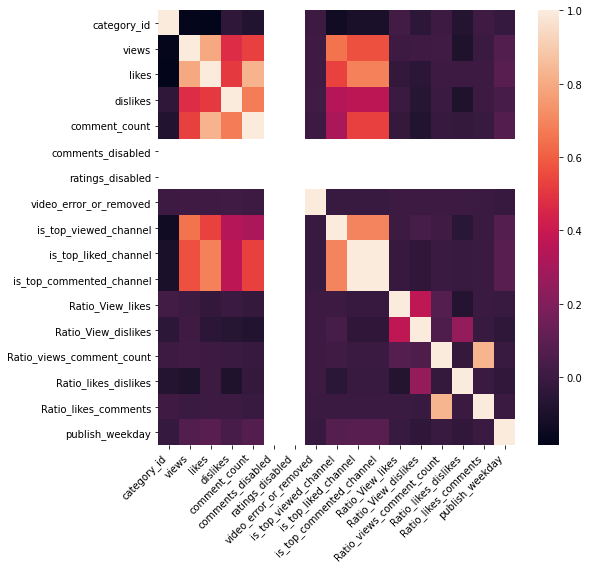

In [18]:
data = df
corr = data.corr()
plt.figure(figsize=(8, 8))
ax = sns.heatmap(
    corr,
    
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right');

## Deleting columns that aren't correlated

In [15]:
df = df.drop(['trending_date','publish_date','publish_time',
              'tags','title','description','channel_title'],axis=1,inplace=False)
print("features:\n", df.columns)

features:
 Index(['category_id', 'views', 'likes', 'dislikes', 'comment_count',
       'comments_disabled', 'ratings_disabled', 'video_error_or_removed',
       'is_top_viewed_channel', 'is_top_liked_channel',
       'is_top_commented_channel', 'Ratio_View_likes', 'Ratio_View_dislikes',
       'Ratio_views_comment_count', 'Ratio_likes_dislikes',
       'Ratio_likes_comments', 'publish_weekday'],
      dtype='object')


## Setting up training and testing data

After copious testing, I determined that Extra Trees Regression outperformed Random Forest, Ridge Regression, and a few other models. It was also much quicker than Random Forest and Ridge. So, We'll use Extra Trees Regression through GridSearchCV as the model

In [16]:
likes = df['likes']
df_like=df.drop(['likes'],axis=1,inplace=False)

views = df['views']
df_views = df.drop(['views', 'Ratio_likes_dislikes'], axis=1, inplace=False)

comment_count = df['comment_count']
df_comment = df.drop(['comment_count'], axis=1, inplace=False)

In [17]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
def ModelTest(attribute_to_predict, test_size):
    label = df[attribute_to_predict]
    df_features = df.drop([attribute_to_predict], axis=1, inplace=False)
    x_train, x_test, y_train, y_test = train_test_split(df_features, label, test_size=test_size, shuffle=False)
    N_estimator = [130, 135, 140]
    depth = [20, 25, 30]
    params = [{'n_estimators': N_estimator, 'max_depth': depth}]
    ETR = ExtraTreesRegressor()
    csv= GridSearchCV(ETR, params, cv=3, verbose=1, scoring='r2', n_jobs=-1)
    csv.fit(x_train, y_train)
    print("Best HyperParameters: ", csv.best_params_)
    print("Hyper Parameter Score", csv.best_score_)
    mean_scores = csv.cv_results_['mean_test_score'].reshape(len(N_estimator),len(depth))

    max_depth = csv.best_params_['max_depth']
    n_estimators = csv.best_params_['n_estimators']
    final_model = ExtraTreesRegressor(n_estimators=n_estimators, max_depth=max_depth)
    final_model.fit(x_train, y_train)
    y_pred = final_model.predict(x_test)
    print("Test R^2: ", final_model.score(x_test, y_test))
    model_results = {'True Label': y_test, 'Predicted Label': y_pred}
    results_df = pd.DataFrame(data=model_results)
    print(results_df)


ModelTest('likes', 0.2)
ModelTest('views', 0.2)
ModelTest('comment_count', 0.2)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best HyperParameters:  {'max_depth': 20, 'n_estimators': 130}
Hyper Parameter Score 0.9424836098628662
Test R^2:  0.9205588982891493
       True Label  Predicted Label
31087      235811     2.339008e+05
31088        4248     4.285592e+03
31089       23453     2.299620e+04
31090       22649     2.244628e+04
31091     1334654     1.317932e+06
...           ...              ...
38911      268088     2.913708e+05
38912       61998     6.865341e+04
38913      394830     4.080371e+05
38914      151870     1.555732e+05
38915       18271     1.890856e+04

[7494 rows x 2 columns]
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best HyperParameters:  {'max_depth': 25, 'n_estimators': 130}
Hyper Parameter Score 0.935711105478715
Test R^2:  0.9808498729714691
       True Label  Predicted Label
31087     7517916     7.499164e+06
31088      383380     3.812351e+05
31089     1641198     1.614597e+06
31090     1058966     1.049478

## Very Accurate!

In summary:
1. Likes -> r2 = 0.921
2. Views -> r2 = 0.981
3. Comments -> r2 = 0.783

So, we can conclude that views and likes are the easiest features to predict, while comment counts are much harder to predict.